<a href="https://colab.research.google.com/github/rohandawar/handgesture/blob/main/hand_gesture_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# from google.colab import files
# uploaded = files.upload()

Mounted at /content/drive


In [3]:
import io
#load data
data_test=pd.read_csv("https://raw.githubusercontent.com/VinitaSilaparasetty/hand-gesture-recognition/main/sign_mnist_test.csv")
data_train=pd.read_csv("/content/drive/MyDrive/sign_mnist_train.csv")
#data_train = pd.read_csv(io.BytesIO(uploaded['sign_mnist_train.csv']))

In [4]:
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205.0,206.0,206.0,207.0,207.0,206.0,206.0,204.0,205.0,204.0,203.0,202.0,142.0,151.0,160.0,172.0,196.0,188.0,188.0,190.0,135.0,96.0,86.0,77.0,77.0,79.0,176.0,205.0,207.0,207.0,207.0,207.0,207.0,207.0,206.0,206.0,206.0,204.0,203.0,202.0
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100.0,78.0,120.0,157.0,168.0,107.0,99.0,121.0,133.0,97.0,95.0,120.0,135.0,116.0,95.0,79.0,69.0,86.0,139.0,173.0,200.0,185.0,175.0,198.0,124.0,118.0,94.0,140.0,133.0,84.0,69.0,149.0,128.0,87.0,94.0,163.0,175.0,103.0,135.0,149.0
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203.0,204.0,203.0,201.0,200.0,200.0,199.0,198.0,196.0,195.0,194.0,193.0,198.0,166.0,132.0,114.0,89.0,74.0,79.0,77.0,74.0,78.0,132.0,188.0,210.0,209.0,206.0,205.0,204.0,203.0,202.0,201.0,200.0,199.0,198.0,199.0,198.0,195.0,194.0,195.0
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247.0,242.0,233.0,231.0,230.0,229.0,227.0,225.0,223.0,221.0,220.0,216.0,58.0,51.0,49.0,50.0,57.0,60.0,17.0,15.0,18.0,17.0,19.0,1.0,159.0,255.0,237.0,239.0,237.0,236.0,235.0,234.0,233.0,231.0,230.0,226.0,225.0,222.0,229.0,163.0
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90.0,77.0,88.0,117.0,123.0,127.0,129.0,134.0,145.0,152.0,156.0,179.0,105.0,106.0,105.0,104.0,104.0,104.0,175.0,199.0,178.0,152.0,136.0,130.0,136.0,150.0,118.0,92.0,85.0,76.0,92.0,105.0,105.0,108.0,133.0,163.0,157.0,163.0,164.0,179.0


In [5]:
data_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [6]:
data_train.iloc[0,1:] #fetching all the pixels for row "0"

pixel1      107.0
pixel2      118.0
pixel3      127.0
pixel4      134.0
pixel5      139.0
            ...  
pixel780    206.0
pixel781    206.0
pixel782    204.0
pixel783    203.0
pixel784    202.0
Name: 0, Length: 784, dtype: float64

In [7]:
#Function to see images
def show_img(img, df): #img = image number, df = data set
  label = df['label'][img] #find a particular images
  pixels = df.iloc[img,1:] # extarct all the values from this row
  #print(pixels)
  pixels = np.array(pixels,dtype='uint8')
  pixels = pixels.reshape((28,28))
  plt.title('Label is {label}'.format(label=label))
  plt.imshow(pixels, cmap='gray')
  plt.show()


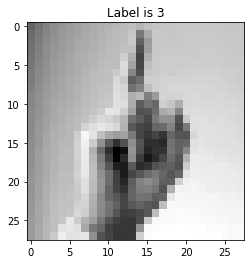

In [8]:
show_img(0,data_train)

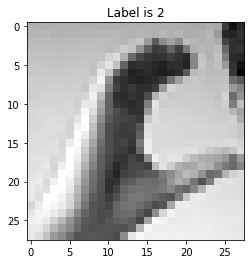

In [9]:
show_img(20,data_test)

In [10]:
#Extract labels

y_train = data_train['label']
y_test = data_test['label']

#Remove the label coloumn from both the dataset
del data_train['label']
del data_test['label']

In [11]:
#Lable encoding (label Binarizer)

label_binarizer = LabelBinarizer() #usually used for y labels

In [12]:
y_train = label_binarizer.fit_transform(y_train)


y_test = label_binarizer.fit_transform(y_test)

In [13]:
x_train = data_train.values

x_test = data_test.values

In [14]:
#normalization

x_train = x_train/255
x_test = x_test/255



In [15]:
#reshape to fit CNN
x_train = x_train.reshape(-1,28,28,1)

x_test = x_test.reshape(-1,28,28,1)


In [16]:
#data Augmentation
data_generator = ImageDataGenerator(
    featurewise_center = False, #input mean would be 0
    samplewise_center = False, #sample mean to 0
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False, 
    rotation_range = 10, #0 to 180 degrees.
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = False,
    vertical_flip = False
)

data_generator.fit(x_train)

In [17]:
#build model
model = Sequential()
model.add(Conv2D(75, (3,3), strides=1,padding = 'same', activation='relu', input_shape= (28,28,1)))
model.add(BatchNormalization()) # Normalization, re-center & re-scaling
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(50, (3,3), strides=1,padding = 'same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(25, (3,3), strides=1,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=24, activation='softmax'))

In [18]:
#compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Set learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2, 
                                            verbose = 1,
                                            factor = 0.5, 
                                            min_lr = 0.00001)

In [21]:
model.fit(data_generator.flow(x_train,y_train, batch_size=128), 
          epochs=20, 
          validation_data=(x_test,y_test), 
          callbacks = learning_rate_reduction)

Epoch 1/20
3/3 [==============================] - 2s 728ms/step - loss: 3.2910 - accuracy: 0.1337 - val_loss: 3.1774 - val_accuracy: 0.0342
Epoch 2/20
3/3 [==============================] - 1s 553ms/step - loss: 3.2128 - accuracy: 0.0465 - val_loss: 3.1774 - val_accuracy: 0.0342
Epoch 3/20
3/3 [==============================] - 1s 570ms/step - loss: 3.2293 - accuracy: 0.0465 - val_loss: 3.1777 - val_accuracy: 0.0342

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
3/3 [==============================] - 1s 626ms/step - loss: 3.1699 - accuracy: 0.0610 - val_loss: 3.1778 - val_accuracy: 0.0342
Epoch 5/20
3/3 [==============================] - 1s 694ms/step - loss: 3.1676 - accuracy: 0.0494 - val_loss: 3.1778 - val_accuracy: 0.0342

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/20
3/3 [==============================] - 1s 556ms/step - loss: 3.1818 - accuracy: 0.0523 - val_loss: 3.1778 - val_accuracy: 0.034

In [22]:
#check final accuracy
model.evaluate(x_test, y_test)

225/225 [==============================] - 1s 5ms/step - loss: 3.1778 - accuracy: 0.0602


[3.177809476852417, 0.06023424491286278]

In [25]:
predictions = model.predict_classes(x_test)
for i in range(len(predictions)):
  if (predictions[i]>=9 or predictions[i]>=25):
    predictions[i]+=1

predictions[:5]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1, 1, 1, 1, 1])

In [26]:
#save model 
model.save('hand_gesture.h5')